# Inference

In [1]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

## Imports
All of the IceVision components can be easily imported with a single line.


In [2]:
from icevision.all import *

/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


## List of images for inference

Please store your images in a folder, and populate the `path_to_folder` variable with the corresponding folder name.

In [3]:
# Pick your images folder
path_to_image_folder = "../data/inglourious_basterds_img_series/"
img_files = get_image_files(path_to_image_folder)
# img_files

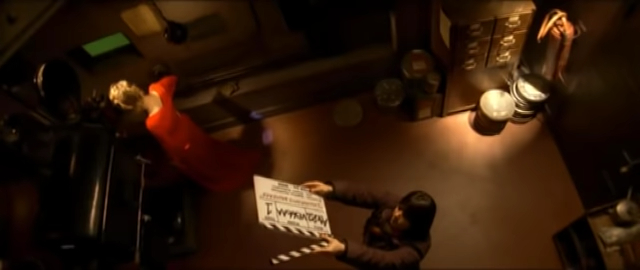

In [4]:
img = PIL.Image.open(img_files[0])
img

## Loading a checkpoint and creating the corresponding model

The checkpoint file can be either a local file or an URL

In [5]:
checkpoint_path = '../models/2022-10-03_resnet_slates_147.pth'

In [6]:
from icevision.models import *

checkpoint_and_model = model_from_checkpoint(checkpoint_path, map_location='cuda')

load checkpoint from local path: ../models/2022-10-03_resnet_slates_147.pth


/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
2022-10-09 06:23:24,368 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-10-09 06:23:24,369 - mmcv - INFO - load model from: torchvision://resnet101
2022-10-09 06:23:24,370 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
2022-10-09 06:23:25,244 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-10-09 06:23:25,444 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-10-09 06:23:25,468 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-10-09 06:23:25,474 - mmcv - INFO - initialize 

2022-10-09 06:23:25,691 - mmcv - INFO - 
backbone.layer2.1.bn1.bias - torch.Size([128]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,692 - mmcv - INFO - 
backbone.layer2.1.conv2.weight - torch.Size([128, 128, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,692 - mmcv - INFO - 
backbone.layer2.1.bn2.weight - torch.Size([128]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,693 - mmcv - INFO - 
backbone.layer2.1.bn2.bias - torch.Size([128]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,695 - mmcv - INFO - 
backbone.layer2.1.conv3.weight - torch.Size([512, 128, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,695 - mmcv - INFO - 
backbone.layer2.1.bn3.weight - torch.Size([512]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,696 - mmcv - INFO - 
backbone.layer2.1.bn3.bias - torch.Size([512]): 
PretrainedInit: lo

2022-10-09 06:23:25,730 - mmcv - INFO - 
backbone.layer3.3.conv1.weight - torch.Size([256, 1024, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,731 - mmcv - INFO - 
backbone.layer3.3.bn1.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,732 - mmcv - INFO - 
backbone.layer3.3.bn1.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,732 - mmcv - INFO - 
backbone.layer3.3.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,733 - mmcv - INFO - 
backbone.layer3.3.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,733 - mmcv - INFO - 
backbone.layer3.3.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,734 - mmcv - INFO - 
backbone.layer3.3.conv3.weight - torch.Size([1024, 256, 1, 1]): 
P

2022-10-09 06:23:25,766 - mmcv - INFO - 
backbone.layer3.9.bn1.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,766 - mmcv - INFO - 
backbone.layer3.9.bn1.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,767 - mmcv - INFO - 
backbone.layer3.9.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,767 - mmcv - INFO - 
backbone.layer3.9.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,768 - mmcv - INFO - 
backbone.layer3.9.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,768 - mmcv - INFO - 
backbone.layer3.9.conv3.weight - torch.Size([1024, 256, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,769 - mmcv - INFO - 
backbone.layer3.9.bn3.weight - torch.Size([1024]): 
PretrainedInit

2022-10-09 06:23:25,802 - mmcv - INFO - 
backbone.layer3.15.bn1.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,803 - mmcv - INFO - 
backbone.layer3.15.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,803 - mmcv - INFO - 
backbone.layer3.15.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,804 - mmcv - INFO - 
backbone.layer3.15.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,804 - mmcv - INFO - 
backbone.layer3.15.conv3.weight - torch.Size([1024, 256, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,805 - mmcv - INFO - 
backbone.layer3.15.bn3.weight - torch.Size([1024]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,806 - mmcv - INFO - 
backbone.layer3.15.bn3.bias - torch.Size([1024]): 
Pretrain

2022-10-09 06:23:25,839 - mmcv - INFO - 
backbone.layer3.21.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,840 - mmcv - INFO - 
backbone.layer3.21.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,840 - mmcv - INFO - 
backbone.layer3.21.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,841 - mmcv - INFO - 
backbone.layer3.21.conv3.weight - torch.Size([1024, 256, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,841 - mmcv - INFO - 
backbone.layer3.21.bn3.weight - torch.Size([1024]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,842 - mmcv - INFO - 
backbone.layer3.21.bn3.bias - torch.Size([1024]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-10-09 06:23:25,842 - mmcv - INFO - 
backbone.layer3.22.conv1.weight - torch.Size([256, 1024, 1

2022-10-09 06:23:25,875 - mmcv - INFO - 
neck.fpn_convs.0.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FasterRCNN  
 
2022-10-09 06:23:25,876 - mmcv - INFO - 
neck.fpn_convs.1.conv.weight - torch.Size([256, 256, 3, 3]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-10-09 06:23:25,876 - mmcv - INFO - 
neck.fpn_convs.1.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FasterRCNN  
 
2022-10-09 06:23:25,877 - mmcv - INFO - 
neck.fpn_convs.2.conv.weight - torch.Size([256, 256, 3, 3]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-10-09 06:23:25,877 - mmcv - INFO - 
neck.fpn_convs.2.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FasterRCNN  
 
2022-10-09 06:23:25,878 - mmcv - INFO - 
neck.fpn_convs.3.conv.weight - torch.Size([256, 256, 3, 3]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-10-09 06:23:25,878 -

In [7]:
# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]

In [8]:
model_type

<module 'icevision.models.mmdet.models.faster_rcnn' from '/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/icevision/models/mmdet/models/faster_rcnn/__init__.py'>

In [9]:
backbone

In [10]:
class_map

<ClassMap: {'background': 0, 'Slate': 1}>

In [11]:
img_size

512

## Get Model Object

`model_from_checkpoint(checkpoint_path)` returns a dictionary: `checkpoint_and_model`. The model object is stored in `checkpoint_and_model["model"]`. 

In [12]:
# Get model object
# The model is automatically set in the evaluation mode
model = checkpoint_and_model["model"]

# Check device
device=next(model.parameters()).device
device

device(type='cpu')

In [13]:
model.to('cuda')

device=next(model.parameters()).device
device

device(type='cuda', index=0)

In [14]:
# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

## Single Image Inference

The `end2end_detect()` not only compute predictions for a single image but also automatically adjust predicted boxes to the original image size

/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


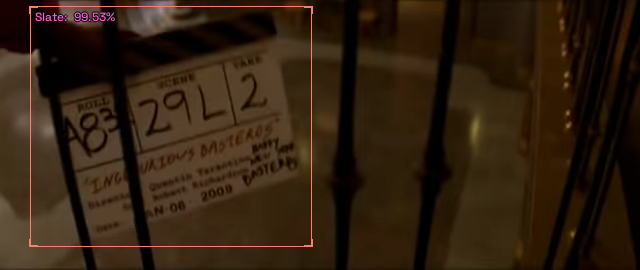

In [15]:
img_index = 140
detection_threshold = 0.5

img = PIL.Image.open(img_files[img_index])

pred_dict  = model_type.end2end_detect(
    img, 
    valid_tfms,
    model,
    class_map=class_map,
    detection_threshold=detection_threshold
)

pred_dict['img']

## Save out the image with bbox:

In [19]:
# pred_dict['img'].save(f"../data/inglourious_bboxes/{img_index}.jpg")

# Loop Through Many Images:

In [21]:
detection_threshold = 0.5

for img_idx in range(len(img_files)):
    img = PIL.Image.open(img_files[img_idx])

    pred_dict = model_type.end2end_detect(
        img, 
        valid_tfms,
        model,
        class_map=class_map,
        detection_threshold=detection_threshold
    )

    pred_dict['img'].save(f"../data/inglourious_bboxes/{img_idx}.jpg")

/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


## Batch Inference

The following option shows to do generate inference for a set of images. The latter is processed in batches.

In [ ]:
# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True, detection_threshold=0.50)

In [ ]:
# You may need to un-comment this in certain environments to preview images:
%matplotlib inline
show_preds(preds=preds[0:5])

## How to export inferences as COCO annotations

These will match the dimensions of the original images. This could be useful if you'd like to create preliminary pseudo-annotations for unlabeled data:

In [ ]:
from icevision.data.convert_records_to_coco_style import export_batch_inferences_as_coco_annotations

In [ ]:
info = {
    "year": "2022",
    "version": "1",
    "description": "Exported from IceVision",
    "contributor": "Awesome contributor",
    "url": "https://lazyannotator.fun",
    "date_created": "2022-08-05T20:13:09+00:00"
}

In [ ]:
licenses = [
    {
        "name": "Creative Commons Attribution 4.0",
        "id": 0,
        "url": "https://creativecommons.org/licenses/by/4.0/legalcode",
    }
]

In [ ]:
export_batch_inferences_as_coco_annotations(
    preds=preds,
    img_files=img_files,
    transforms=valid_tfms,
    class_map=class_map,
    output_filepath="../data/annotations/2022-09-27_preds_to_check_then_combine.json",
    info=info,
    licenses=licenses,
)

### Preview predictions on original image:

In [ ]:
# Index of image you'd like to check
i = 33

this_pred = preds[i]
record = this_pred.pred

# Draw that image
pred_img = draw_record(
        record=this_pred,
        class_map=class_map,
        display_label=True,
        display_score=True,
        display_bbox=True,
        font_path=get_default_font(),
        font_size=12,
        label_color=("#FF59D6"),
        return_as_pil_img=True,
    )

pred_img